<a href="https://colab.research.google.com/github/ibenatar-96/Bayesian-Modelling-RL/blob/main/Bayesian_Modelling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/
!pip install numpyro
!git clone https://github.com/ibenatar-96/Bayesian-Modelling-RL
%cd /content/Bayesian-Modelling-RL
!git pull
%cd /content/

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 4.4 MB/s eta 0:00:00
Cloning into 'Bayesian-Modelling-RL'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 405 (delta 36), reused 38 (delta 15), pack-reused 335
Receiving objects: 100% (405/405), 9.07 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (235/235), done.
/content/Bayesian-Modelling-RL
Already up to date.
/content


In [43]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax
import sys
import os
import time
sys.path.append('/content/Bayesian-Modelling-RL')
import actions
import environment
import utils
import solver
import actions

numpyro.set_host_device_count(4)

In [3]:
def init_env(log_file):
    """
    Inits runtime env, opens new observations log file, and resets utils.INIT_MODEL_PARAMETERS,
    which is a dictionary that holds initial user belief about action probabilities
    for example, utils.INIT_MODEL_PARAMETERS = {
        ('ai_mark', 5): 0.8,
        ('ai_mark', 1): 1.0),
        ...
    }
    For every action in actions_module that does not appear in the INIT_MODEL_PARAMETERS, it sets a new entry in the dict with value 1.0
    """
    open(log_file, 'w').close()
    for (fn_action, action_param) in actions.Actions().get_actions():
        if fn_action not in utils.IGNORE_ACTIONS and (fn_action, action_param) not in utils.INIT_MODEL_PARAMETERS:
            utils.INIT_MODEL_PARAMETERS[(fn_action, action_param)] = 1.0

In [4]:
log_file = "observations.log"
init_env(log_file)
model_parameters = utils.INIT_MODEL_PARAMETERS
slvr = solver.Solver(model_parameters, environment, log_file)
slvr.run()

Agent Q-Learning: 100%|██████████| 50/50 [00:01<00:00, 25.79it/s]


Total Time: 0:00:01.949595
Agent Playing REAL PARAMETERS Tic-Tac-Toe

	Testing 12 Tic-Tac-Toe Games


Agent Playing Tic-Tac-Toe..: 100%|██████████| 12/12 [00:00<00:00, 77.88it/s]

	Total Games Won: 2/12



	Playing Real & Collecting Logs 15 Tic-Tac-Toe Games


Playing Real Tic-Tac-Toe & Collecting Logs..: 100%|██████████| 15/15 [00:00<00:00, 94.80it/s]

	Total Games Won: 3/15


In [42]:
model_beta_parameters = {}
fn_numeric_mapping = {}
posterior_model_parameters = {}

# Parsing Observation file
As defined in the description.

In [7]:
def parse_obs(obs_file):
    """
    Parses the Observation File, returns a List of tuples,
    where each tuple is composed of (State, (Function, Action Parameter), Next State)
    for example:
    State: [-1, 1, 0, -1, 0, -1, 1, 0, 0] where -1 indicates 'X' on the Board, 1 indicates 'O', and 0 indicates None (empty cell)
    (Function, Action Parameter): (0, 5) -> 0 is the number assigned for the function 'ai_mark', mapping is located in fn_numeric_mapping
    Next State: [-1, 1, 0, -1, 1, -1, 1, 0, 0].

    0 is mapped to 'ai_mark' function in global fn_numeric_mapping variable. This mapping exists because NumPyro
    MCMC expects numeric values when running inference.

    This Function also adds initial 'alpha' and 'beta' parameters to the global model_beta_parameters for every NEW
    fn_action and action_param it encounters.
    for example - model_beta_parameters = {
    (0, 5): {'alpha': 1, 'beta': 1},
    (0, 1): {'alpha': 1, 'beta': 1} ... }
    """

    #Converts states from: [['X', 'O', None], ['X', None, 'X'], ['O', None, None]] to [-1, 1, 0, -1, 0, -1, 1, 0, 0]
    #Meaning, creating a minimal state representation, where 'X' is marked a -1, 'O' as 1, and None as 0.
    def minimal_state(state):
        minimal_repr = []
        for i in range(len(state)):
            for j in range(len(state[i])):
                if state[i][j] == 'X':
                    minimal_repr.append(-1)
                elif state[i][j] == 'O':
                    minimal_repr.append(1)
                else:
                    minimal_repr.append(0)
        return minimal_repr

    obs_list = []
    fn_numeric_count = 0
    global model_beta_parameters, fn_numeric_mapping
    with open(obs_file, "r") as obs_log:
        for episode in obs_log:
            episode = episode.strip()  # Remove leading/trailing whitespaces and newlines
            episode_list = eval(episode)  # Convert the line string to a list
            for (state, (fn_name, action_param), next_state) in episode_list:
                if fn_name in utils.IGNORE_ACTIONS:
                    continue
                if fn_name in fn_numeric_mapping.keys():
                    fncnumeric = fn_numeric_mapping[fn_name]
                else:
                    fn_numeric = fn_numeric_count
                    fn_numeric_mapping[fn_name] = fn_numeric_count
                    fn_numeric_count += 1
                obs_list.append((minimal_state(state), (fn_numeric, action_param), minimal_state(next_state)))
                if not (fn_numeric, action_param) in model_beta_parameters:
                    model_beta_parameters[(fn_numeric, action_param)] = {'alpha': 1, 'beta': 1}
    model_beta_parameters = dict(sorted(model_beta_parameters.items()))
    return obs_list

In [46]:
obs_list = parse_obs(log_file)

In [47]:
def ai_model(obs=None):
    """
    (Tic-Tac-Toe) AI Agent model with NumPyro.
    p is a dictionary mapping (function, action parameter) -> sample from Beta distribution using (alpha, beta).
    obs = [
    ([-1,1,0,...], (0,3), [-1,1,1,...]),
    ([-1,1,...,0], (0,9), [-1,1,...,1]),
    ]
    """
    # p ~ Beta(alpha, beta)
    global model_beta_parameters
    p = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
    # with numpyro.plate(f"obs", size=len(model_beta_parameters.keys())):
    #     for key in model_beta_parameters.keys():
    #         success = [1 if entry[0] != entry[2] else 0 for entry in obs if entry[1] == key] if obs is not None else None
    #         if success is not None:
    #             print(f"key: {key}, success: {success}")
    #             success = jax.numpy.array(success)
    #         numpyro.sample(f"o{key}", dist.Bernoulli(p[key]), obs=success)
    if obs is not None:
        for i in range(len(obs)):
            s, a, snext = obs[i]
            p_i = p[a]
            success = jax.numpy.array([1 if s != snext else 0])
            numpyro.sample(f"success{i}", dist.Bernoulli(p_i), obs=success)

Observation List:
i: 0, obs: ([0, 0, 0, 0, 0, 0, -1, 0, 0], (0, 3), [0, 0, 1, 0, 0, 0, -1, 0, 0])
i: 1, obs: ([0, -1, 1, 0, 0, 0, -1, 0, 0], (0, 1), [1, -1, 1, 0, 0, 0, -1, 0, 0])
i: 2, obs: ([1, -1, 1, 0, 0, -1, -1, 0, 0], (0, 5), [1, -1, 1, 0, 1, -1, -1, 0, 0])
i: 3, obs: ([1, -1, 1, 0, 1, -1, -1, -1, 0], (0, 4), [1, -1, 1, 1, 1, -1, -1, -1, 0])
i: 4, obs: ([0, 0, 0, -1, 0, 0, 0, 0, 0], (0, 6), [0, 0, 0, -1, 0, 1, 0, 0, 0])
i: 5, obs: ([0, 0, 0, -1, 0, 1, 0, 0, -1], (0, 7), [0, 0, 0, -1, 0, 1, 1, 0, -1])
i: 6, obs: ([-1, 0, 0, -1, 0, 1, 1, 0, -1], (0, 3), [-1, 0, 1, -1, 0, 1, 1, 0, -1])
i: 7, obs: ([0, 0, 0, 0, 0, -1, 0, 0, 0], (0, 1), [1, 0, 0, 0, 0, -1, 0, 0, 0])
i: 8, obs: ([1, 0, -1, 0, 0, -1, 0, 0, 0], (0, 2), [1, 1, -1, 0, 0, -1, 0, 0, 0])
i: 9, obs: ([1, 1, -1, -1, 0, -1, 0, 0, 0], (0, 8), [1, 1, -1, -1, 0, -1, 0, 1, 0])
i: 10, obs: ([0, 0, 0, 0, 0, 0, 0, -1, 0], (0, 5), [0, 0, 0, 0, 0, 0, 0, -1, 0])
i: 11, obs: ([0, -1, 0, 0, 0, 0, 0, -1, 0], (0, 5), [0, -1, 0, 0, 0, 0, 0, -1

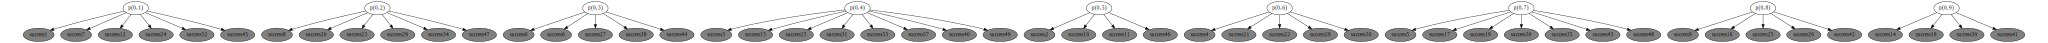

In [48]:
print("Observation List:")
for i, elem in enumerate(obs_list):
    print(f"i: {i}, obs: {elem}")
numpyro.render_model(ai_model, model_args=(obs_list,))

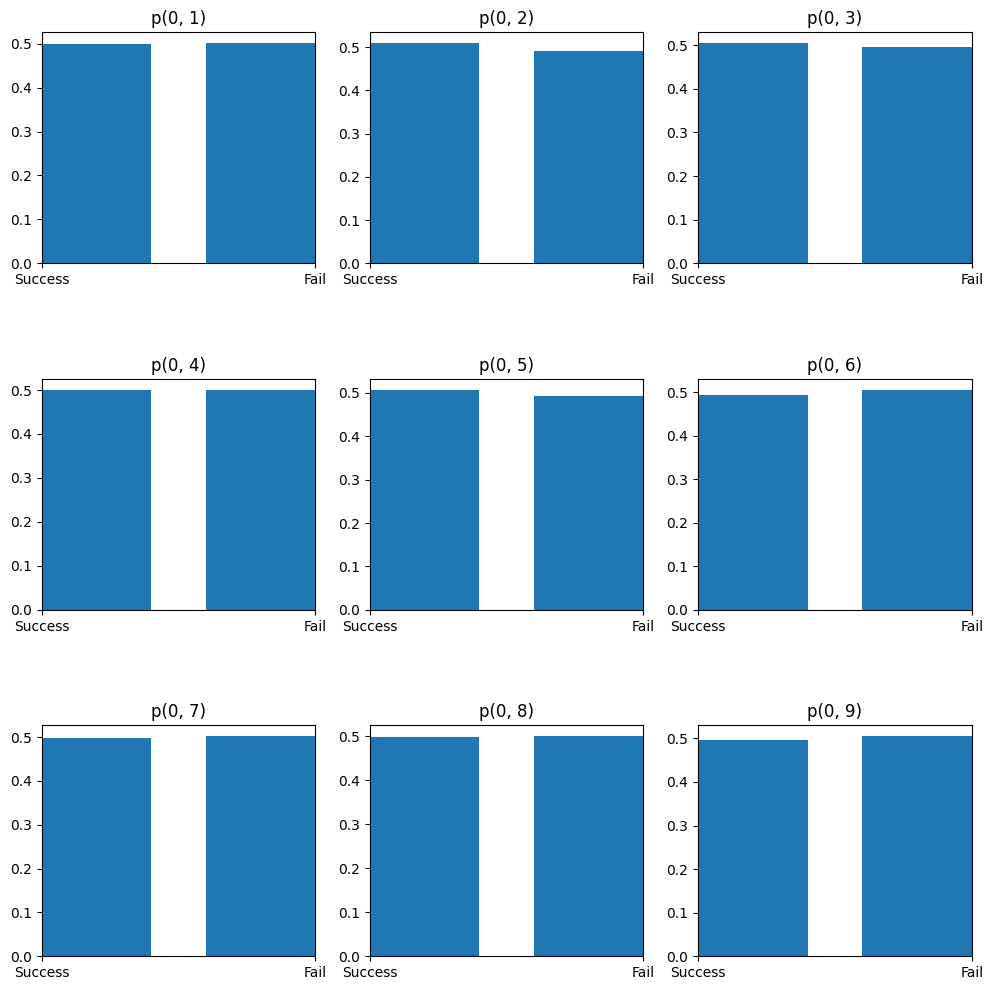

In [49]:
"""
Evaluates Prior Predictive from the Prior Dist.
Expecting to see mass in the bar where observation and imaginations are aligned.
"""
prior_predi = numpyro.infer.Predictive(ai_model, num_samples=10000)
prior_samples = prior_predi(jax.random.PRNGKey(int(time.time() * 1E6)))

num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("prior predictive")
for i in range(num_rows):
    for j in range(num_cols):
        key = list(model_beta_parameters.keys())[i*3 + j]
        o_key = f"p{str(key)}"
        x_titles = ["Success", "Fail"]
        axs[i, j].set_title(o_key)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(prior_samples[o_key] > 0.5, axis=0)
        fail_counts = np.sum(prior_samples[o_key] < 0.5, axis=0)
        normalized_vector = [np.mean(success_counts), np.mean(fail_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

In [50]:
"""
Runs Inference using MCMC.
"""
nuts_kernel = numpyro.infer.NUTS(ai_model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)
mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=obs_list)
mcmc.print_summary()

<ipython-input-50-2a26e5c531c5>:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 5500/5500 [00:10<00:00, 521.87it/s, 7 steps of size 5.65e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p(0, 1)      0.88      0.11      0.91      0.72      1.00  31343.75      1.00
   p(0, 2)      0.87      0.11      0.91      0.72      1.00  30912.51      1.00
   p(0, 3)      0.86      0.12      0.89      0.68      1.00  29341.59      1.00
   p(0, 4)      0.90      0.09      0.93      0.77      1.00  28948.45      1.00
   p(0, 5)      0.50      0.19      0.50      0.19      0.81  32488.06      1.00
   p(0, 6)      0.86      0.12      0.89      0.68      1.00  31399.29      1.00
   p(0, 7)      0.89      0.10      0.92      0.75      1.00  29644.70      1.00
   p(0, 8)      0.86      0.12      0.89      0.68      1.00  30071.74      1.00
   p(0, 9)      0.83      0.14      0.87      0.62      1.00  33302.03      1.00

Number of divergences: 0


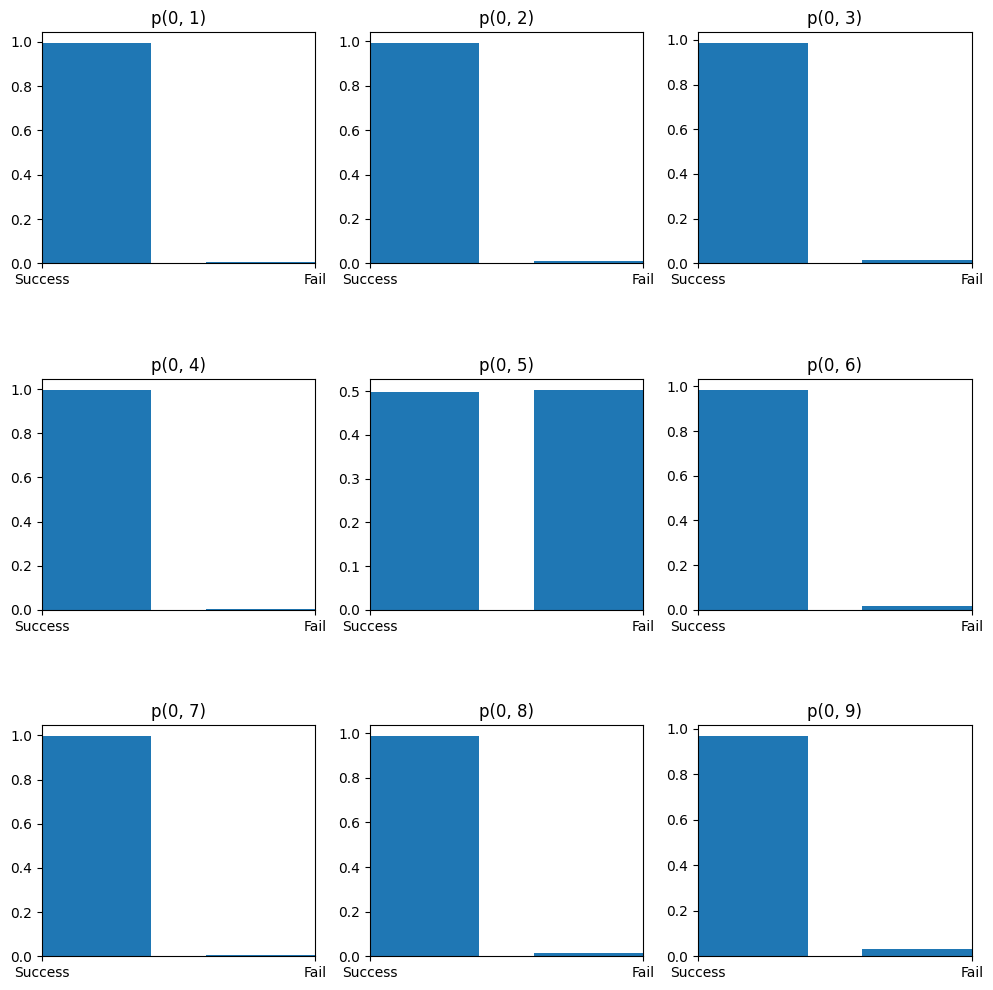

In [53]:
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("posterior")
for i in range(num_rows):
    for j in range(num_cols):
        key = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str(key)}"
        x_titles = ["Success", "Fail"]
        axs[i, j].set_title(p_key)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(mcmc.get_samples()[p_key] > 0.5, axis=0)
        fail_counts = np.sum(mcmc.get_samples()[p_key] < 0.5, axis=0)
        normalized_vector = [np.mean(success_counts), np.mean(fail_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)

        # p_key = f"p{str(key)}"
        # axs[i, j].set_title(p_key)
        # axs[i, j].set_xlabel("p")
        # axs[i, j].hist(mcmc.get_samples()[p_key], density=True, bins='auto')
plt.show()


stat	p(0, 1)
-------------
mean	0.875
stddev	0.110
  0%	0.210
  2%	0.590
 25%	0.822
 50%	0.906
 75%	0.959
 98%	0.996
100%	1.000


stat	p(0, 2)
-------------
mean	0.874
stddev	0.111
  0%	0.186
  2%	0.591
 25%	0.818
 50%	0.906
 75%	0.960
 98%	0.997
100%	1.000


stat	p(0, 3)
-------------
mean	0.858
stddev	0.123
  0%	0.148
  2%	0.540
 25%	0.796
 50%	0.891
 75%	0.953
 98%	0.996
100%	1.000


stat	p(0, 4)
-------------
mean	0.901
stddev	0.091
  0%	0.264
  2%	0.661
 25%	0.859
 50%	0.927
 75%	0.969
 98%	0.997
100%	1.000


stat	p(0, 5)
-------------
mean	0.500
stddev	0.188
  0%	0.013
  2%	0.150
 25%	0.359
 50%	0.499
 75%	0.639
 98%	0.854
100%	0.977


stat	p(0, 6)
-------------
mean	0.857
stddev	0.124
  0%	0.190
  2%	0.540
 25%	0.790
 50%	0.891
 75%	0.954
 98%	0.996
100%	1.000


stat	p(0, 7)
-------------
mean	0.889
stddev	0.099
  0%	0.291
  2%	0.629
 25%	0.842
 50%	0.917
 75%	0.965
 98%	0.997
100%	1.000


stat	p(0, 8)
-------------
mean	0.857
stddev	0.123
  0%	0.136
  2%	0.542
 25%	0.793
 50%	0

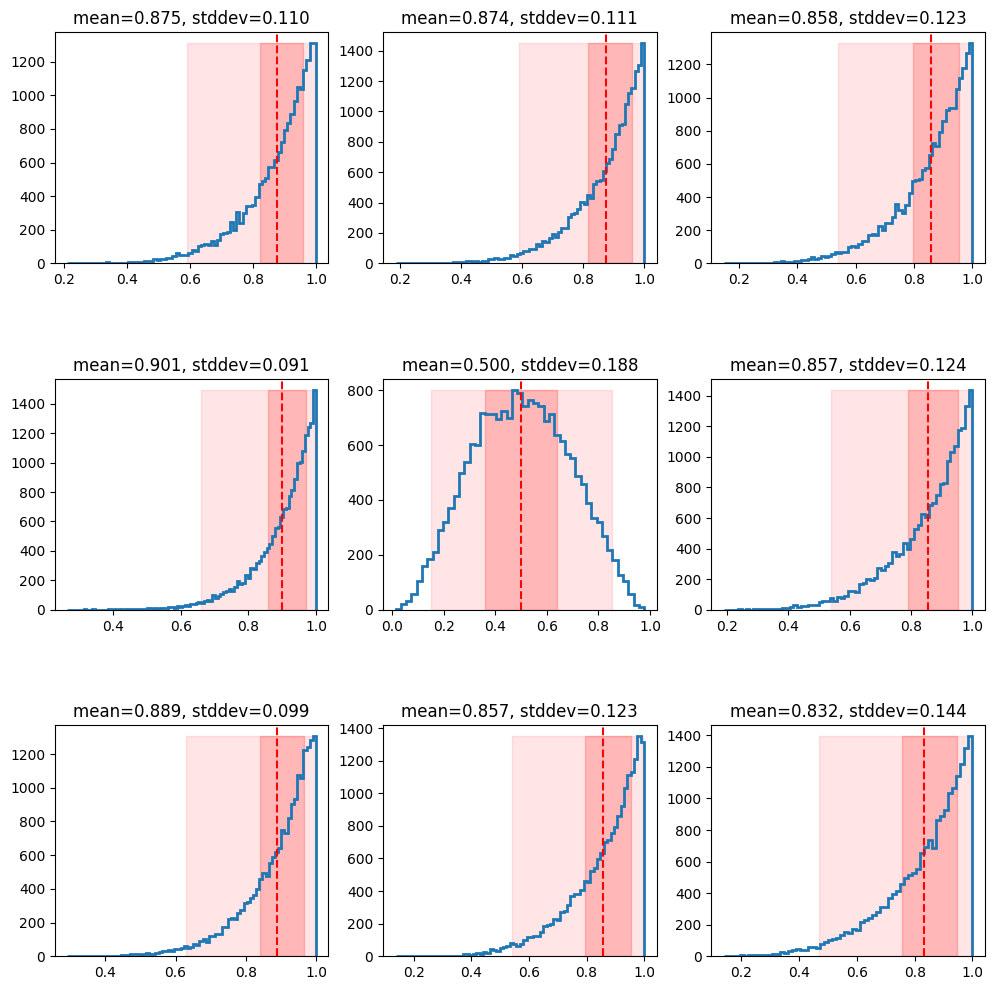

In [58]:
"""
Summarizes Posterior, displays attributes such as mean, standard deviation, quantiles.
"""
distribution_stats = {}
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
# obs_list = list(obs.items())
for i in range(num_rows):
    for j in range(num_cols):
        key = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str(key)}"
        p = mcmc.get_samples()[p_key]
        p_mean = p.mean()
        p_stddev = p.std()
        distribution_stats[key] = {'mean': p_mean, 'stddev': p_stddev}
        quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
        pq = np.quantile(p, quantiles)
        print(f"stat\t{p_key}\n-------------")
        print(f"mean\t{p_mean:.3f}")
        print(f"stddev\t{p_stddev:.3f}")
        for q in range(len(quantiles)):
            print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
        print("\n")
        height, _, _ = axs[i, j].hist(p, histtype="step", lw=2, bins="auto", label="posterior")
        axs[i, j].set_title(f"mean={p_mean:.3f}, stddev={p_stddev:.3f}")
        axs[i, j].axvline(p_mean, ls="dashed", color="red", label="mean")
        axs[i, j].fill_betweenx([0, height.max()], pq[1], pq[-2],
                                color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
        axs[i, j].fill_betweenx([0, height.max()], pq[2], pq[-3],
                                color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
plt.show()

In [ ]:
def bayesian_learning(obs_file, prior_model_parameters=None):
    """
    Using the Logs in observations.log,
    """
    obs_list = parse_obs(obs_file)
    posterior_model_parameters = {}
    global model_beta_parameters
    prior_predi = prior_predictive()
    mcmc = inference(obs_list)
    posterior(mcmc, obs_list)
    posterior_predi = posterior_predictive(obs_list, mcmc)
    # p_value(obs, posterior_samples)
    dist_stats = summarize_posterior(mcmc, obs_list)
    for key in obs_list:
        p_key = f"p{str(key)}"
        sample = np.random.choice(mcmc.get_samples()[p_key])
        print(f"sample: {sample}")
        p_mean = dist_stats[key]['mean']
        p_stddev = dist_stats[key]['stddev']
        posterior_model_parameters[key] = sample
        model_beta_parameters[key]['alpha'] = p_mean * (
                ((p_mean * (1 - p_mean)) / p_stddev) - 1)
        model_beta_parameters[key]['beta'] = (1 - p_mean) * (
                ((p_mean * (1 - p_mean)) / p_stddev) - 1)
    fill_post_model_params(posterior_model_parameters, prior_model_parameters)
    print(f"posterior model parameters: {posterior_model_parameters}")
    return posterior_model_parameters
